<a href="https://colab.research.google.com/github/kcalizadeh/phil_nlp/blob/master/non_neural_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Mounting Drive

In [5]:
# this cell mounts drive, sets the correct directory, then imports all functions
# and relevant libraries via the functions.py file
from google.colab import drive
import sys

# install relevent libraries not included with colab
!pip install lime
!pip install symspellpy

drive.mount('/gdrive',force_remount=True)

drive_path = '/gdrive/MyDrive/Colab_Projects/Phil_NLP'

sys.path.append(drive_path)

     |████████████████████████████████| 276kB 5.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=355a818b6111e623b90161bbc0021c231a492374fe891bc13c264e8e797787de
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 2.6MB 5.6MB/s 
Mounted at /gdrive


In [6]:
from functions import *
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the data

In [7]:
df = pd.read_csv('/gdrive/MyDrive/Colab_Projects/Phil_NLP/phil_nlp.csv')

df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,lemmatized_str,tokenized_txt
294635,kapital,marx,communism,But both these limiting conditions are of a ve...,But both these limiting conditions are of a ve...,97,but both these limiting conditions are of a ve...,but both these limit condition be of a very e...,"['But', 'both', 'these', 'limiting', 'conditio..."
32841,complete works,plato,plato,And I suppose you know what a mother does when...,And I suppose you know what a mother does when...,89,and i suppose you know what a mother does when...,and -PRON- suppose -PRON- know what a mother ...,"['And', 'I', 'suppose', 'you', 'know', 'what',..."
26444,complete works,plato,plato,"Well, then, Glaucon, we ve agreed to the follo...","Well, then, Glaucon, we ve agreed to the follo...",350,"well, then, glaucon, we ve agreed to the follo...","well , then , Glaucon , -PRON- ve agree to th...","['Well', ',', 'then', ',', 'Glaucon', ',', 'we..."
279415,the phenomenology of spirit,hegel,german_idealism,When we compare the relation in which knowing ...,When we compare the relation in which knowing ...,172,when we compare the relation in which knowing ...,when -PRON- compare the relation in which kno...,"['When', 'we', 'compare', 'the', 'relation', '..."
244440,off the beaten track,heidegger,phenomenology,By thus bringing itself within itself to itsel...,By thus bringing itself within itself to itsel...,66,by thus bringing itself within itself to itsel...,by thus bring -PRON- within -PRON- to -PRON- ...,"['By', 'thus', 'bringing', 'itself', 'within',..."


In [8]:
stopwords_list = stopwords.words('english') + list(string.punctuation) + ['“','”','...',"''",'’','``', "'", "‘"]
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one'] + stopwords_list

### Baseline NB Bayes Model

In [52]:
# split the data
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [53]:
# vectorize
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=stopwords_list)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [27]:
# build the classifier, train it, get predictions
nb_classifier = MultinomialNB()
nb_classifier.fit(tf_idf_data_train, y_train)
nb_classifier_preds = nb_classifier.predict(tf_idf_data_test)

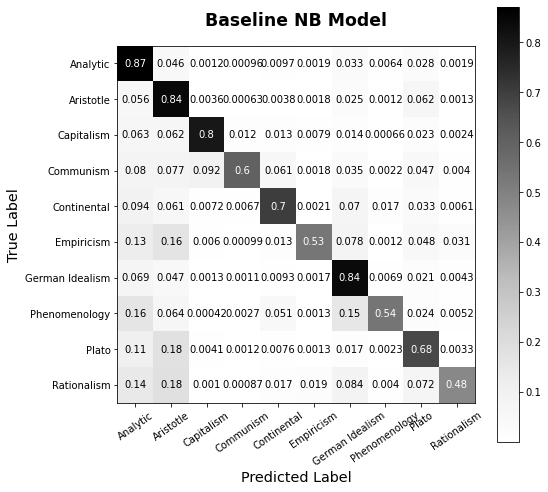

In [28]:
plot_pretty_cf(nb_classifier, tf_idf_data_test, y_test, title='Baseline NB Model')

In [29]:
print(classification_report(y_test, nb_classifier_preds))

                 precision    recall  f1-score   support

       analytic       0.64      0.87      0.74     13474
      aristotle       0.63      0.84      0.72     12673
     capitalism       0.85      0.80      0.83      4559
      communism       0.94      0.60      0.73      4520
    continental       0.83      0.70      0.76      8477
     empiricism       0.91      0.53      0.67      5038
german_idealism       0.71      0.84      0.77     10658
  phenomenology       0.91      0.54      0.68      7150
          plato       0.70      0.68      0.69      9534
    rationalism       0.87      0.48      0.62      5729

       accuracy                           0.73     81812
      macro avg       0.80      0.69      0.72     81812
   weighted avg       0.76      0.73      0.72     81812



73% accuracy over 10 classes is not too bad, but we can at least aim higher than this. If we look at it, a lot of failures were along the lines of lines of class imbalance. 

In [21]:
df['school'].value_counts(normalize=True)

analytic           0.164210
aristotle          0.154805
german_idealism    0.129243
plato              0.117242
continental        0.103653
phenomenology      0.087522
rationalism        0.070287
empiricism         0.062262
capitalism         0.055769
communism          0.055008
Name: school, dtype: float64

Perhaps correcting for class imbalance could improve the model. 

### NB Corrected for Class Imbalance

Here we will use imblearn's over and undersampler to correct for class imbalance.

In [78]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_str'], df['school'])

In [79]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [80]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# to use the sampler, the data must be numerical
y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

le = LabelEncoder()
le.fit(list(y_classes))
y_integers = le.transform(list(y_classes))

# create a dict of labels : their integer representations
label_dict = dict(zip(y_classes, y_integers))

# # get the class weights
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

# convert the target to the numerical categories
y_train = y_train.apply(lambda x: label_dict[x])
y_test = y_test.apply(lambda x: label_dict[x])

In [95]:
flipped_dict = {value:key for key, value in label_dict.items()}
flipped_dict

{0: 'analytic',
 1: 'aristotle',
 2: 'capitalism',
 3: 'communism',
 4: 'continental',
 5: 'empiricism',
 6: 'german_idealism',
 7: 'phenomenology',
 8: 'plato',
 9: 'rationalism'}

#### Try Over Sampling First

In [82]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

rus = RandomOverSampler(sampling_strategy='all')

In [83]:
x_under, y_under = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [84]:
nb_undersampled = MultinomialNB()
nb_undersampled.fit(x_under, y_under)
nb_undersampled_preds = nb_undersampled.predict(tf_idf_data_test)

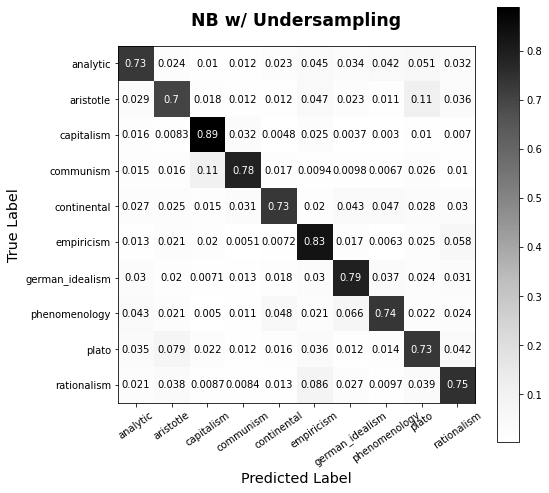

Text(0, 0, 'analytic')


In [135]:
plot_pretty_cf(nb_undersampled, tf_idf_data_test, y_test, 
               title='NB w/ Undersampling', label_dict=flipped_dict)

In [105]:
print(classification_report(y_test, nb_test_smote_preds))

              precision    recall  f1-score   support

           0       0.83      0.72      0.78     13442
           1       0.81      0.70      0.75     12749
           2       0.74      0.89      0.81      4665
           3       0.76      0.79      0.77      4486
           4       0.82      0.74      0.77      8513
           5       0.60      0.82      0.69      5126
           6       0.80      0.79      0.80     10564
           7       0.75      0.73      0.74      7139
           8       0.69      0.72      0.71      9565
           9       0.63      0.75      0.69      5669

    accuracy                           0.75     81918
   macro avg       0.74      0.77      0.75     81918
weighted avg       0.76      0.75      0.75     81918



In [107]:
label_dict

{'analytic': 0,
 'aristotle': 1,
 'capitalism': 2,
 'communism': 3,
 'continental': 4,
 'empiricism': 5,
 'german_idealism': 6,
 'phenomenology': 7,
 'plato': 8,
 'rationalism': 9}

In [131]:
nus = [int('0'), 1, 2, 3]

[flipped_dict[x] for x in nus]

['analytic', 'aristotle', 'capitalism', 'communism']

In [134]:
def plot_pretty_cf(predictor, xtest, ytest, cmap='Greys', normalize='true', 
                   title=None, label_dict={}):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_confusion_matrix(predictor, xtest, ytest, cmap=cmap, normalize=normalize, ax=ax)
    ax.set_title(title, size='xx-large', pad=20, fontweight='bold')
    if label_dict != {}:
      ax.set_xticklabels([label_dict[int(x.get_text())] for x in ax.get_xticklabels()], rotation=35)
      ax.set_yticklabels([label_dict[int(x.get_text())] for x in ax.get_yticklabels()])
    else: 
      ax.set_xticklabels([str(x).replace('_', ' ').title()[12:-2] for x in ax.get_xticklabels()], rotation=35)
      ax.set_yticklabels([str(x).replace('_', ' ').title()[12:-2] for x in ax.get_yticklabels()])
    ax.set_xlabel('Predicted Label', size='x-large')
    ax.set_ylabel('True Label', size='x-large')
    plt.show()

In [7]:
smote = SMOTE()
xtrain_smote, ytrain_smote = smote.fit_resample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [106]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [107]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

print(lemmatizer.lemmatize("I am loving it")) #I am loving it
print(lemmatizer.lemmatize("loving")) #loving
print(lemmatizer.lemmatize("loving", "v")) #love
print(lemmatize_sentence("I am loving it")) #I be love it

I am loving it
loving
love
I be love it


In [108]:
df = df.drop('Unnamed: 0', axis=1)

In [109]:
df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered
132377,search after truth,malebranche,rationalism,"Finally, it follows that we do not see bodies ...","Finally, it follows that we do not see bodies ...",488,"finally, it follows that we do not see bodies ..."
2602,complete works,plato,plato,"is then the pusher (ōthoun), and so is well n...","is then the pusher (ōthoun), and so is well n...",58,"is then the pusher (ōthoun), and so is well n..."
253049,critique of judgement,kant,german_idealism,"In the genus, now as effect, now as cause, con...","In the genus, now as effect, now as cause, con...",141,"in the genus, now as effect, now as cause, con..."
78939,complete works vol 2,aristotle,aristotle,"Nor will it be found in an incomplete, but in ...","Nor will it be found in an incomplete, but in ...",65,"nor will it be found in an incomplete, but in ..."
197371,the order of things,foucault,continental,But there was a necessity lying at the heart o...,But there was a necessity lying at the heart o...,301,but there was a necessity lying at the heart o...


In [110]:
df['sentence_lemmatized'] = df['sentence_lowered'].apply(lemmatize_sentence)

In [111]:
df.sample(5)

,title,author,school,sentence_spacy,sentence_str,sentence_length,sentence_lowered,sentence_lemmatized
267798,the system of ethics,fichte,german_idealism,"Like every virtuous person, the scholar ought ...","Like every virtuous person, the scholar ought ...",75,"like every virtuous person, the scholar ought ...","like every virtuous person , the scholar ought..."
178221,philosophical troubles,kripke,analytic,The same question arises for Sherlock Holmes .,The same question arises for Sherlock Holmes .,46,the same question arises for sherlock holmes .,the same question arises for sherlock holmes .
53137,complete works vol 1,aristotle,aristotle,Some bodies are solidified by both heat and cold.,Some bodies are solidified by both heat and cold.,49,some bodies are solidified by both heat and cold.,some body be solidify by both heat and cold .
52994,complete works vol 1,aristotle,aristotle,"or non tractile, malleable or non malleable, t...","or non tractile, malleable or non malleable, t...",224,"or non tractile, malleable or non malleable, t...","or non tractile , malleable or non malleable ,..."
114928,theodicy,leibniz,rationalism,But it also for divers reasons appears likely ...,But it also for divers reasons appears likely ...,167,but it also for divers reasons appears likely ...,but it also for diver reason appear likely to ...


In [112]:
x_train, x_test, y_train, y_test = train_test_split(df['sentence_lemmatized'], df['school'])

In [113]:
tfidvectorizer = TfidfVectorizer(decode_error='ignore', stop_words=custom_stopwords)
tf_idf_data_train = tfidvectorizer.fit_transform(x_train)
tf_idf_data_test = tfidvectorizer.transform(x_test)

In [114]:
from sklearn.preprocessing import LabelEncoder

y_train_dummies = pd.get_dummies(y_train)
y_classes = y_train_dummies.idxmax(1, skipna=False)

# Instantiate the label encoder
le = LabelEncoder()

# Fit the label encoder to our label series
le.fit(list(y_classes))

# Create integer based labels Series
y_integers = le.transform(list(y_classes))

# Create dict of labels : integer representation
labels_and_integers = dict(zip(y_classes, y_integers))

from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
sample_weights = compute_sample_weight('balanced', y_integers)

class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))

y_train = y_train.apply(lambda x: labels_and_integers[x])
y_test = y_test.apply(lambda x: labels_and_integers[x])

In [116]:
x_under, y_under = rus.fit_sample(tf_idf_data_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [117]:
nb_classifier_smote = MultinomialNB()
nb_classifier_smote.fit(x_under, y_under)
nb_test_smote_preds = nb_classifier_smote.predict(tf_idf_data_test)

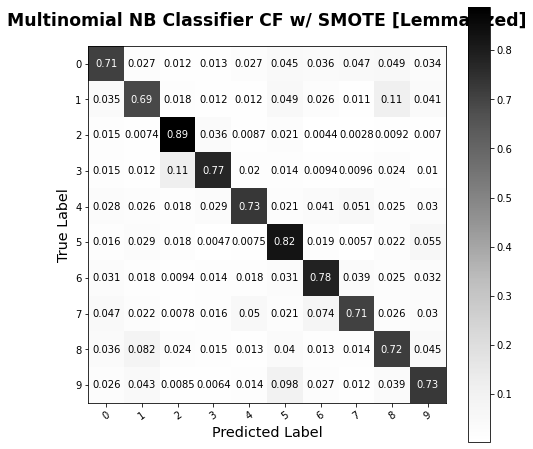

In [118]:
plot_pretty_cf(nb_classifier_smote, tf_idf_data_test, y_test, title='Multinomial NB Classifier CF w/ SMOTE [Lemmatized]')

In [119]:
print(classification_report(y_test, nb_test_smote_preds))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76     13435
           1       0.80      0.69      0.74     12640
           2       0.72      0.89      0.79      4590
           3       0.75      0.77      0.76      4593
           4       0.81      0.73      0.77      8408
           5       0.58      0.82      0.68      5058
           6       0.79      0.78      0.79     10575
           7       0.73      0.71      0.72      7182
           8       0.68      0.72      0.70      9639
           9       0.62      0.73      0.67      5798

    accuracy                           0.74     81918
   macro avg       0.73      0.75      0.74     81918
weighted avg       0.75      0.74      0.74     81918

